In [1]:
%matplotlib notebook
import pandas as pd
from ipyleaflet import Map, basemaps, Rectangle
import matplotlib.pyplot as plt


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import ipywidgets as widgets

### 1. Загрузим данные, полученные на прошлой неделе

In [2]:
data = pd.read_csv('data.csv', index_col=0)
data['datetime'] = pd.to_datetime(data['datetime'])
data.head()

,value,region,datetime,prediction
0,26.0,1075,2016-06-01 00:00:00,17.042110
1,14.0,1075,2016-06-01 01:00:00,7.563181
2,5.0,1075,2016-06-01 02:00:00,6.028013
3,2.0,1075,2016-06-01 03:00:00,5.016545
4,1.0,1075,2016-06-01 04:00:00,10.564125


In [3]:
regions = pd.read_csv('regions.csv').set_index('region')
regions.head()

,west,east,south,north
region,,,,
1075,-74.022246,-74.011135,40.697437,40.705825
1076,-74.022246,-74.011135,40.705825,40.714213
1077,-74.022246,-74.011135,40.714213,40.722601
1125,-74.011135,-74.000023,40.697437,40.705825
1126,-74.011135,-74.000023,40.705825,40.714213


### 2. Представление данных

<IPython.core.display.Javascript object>


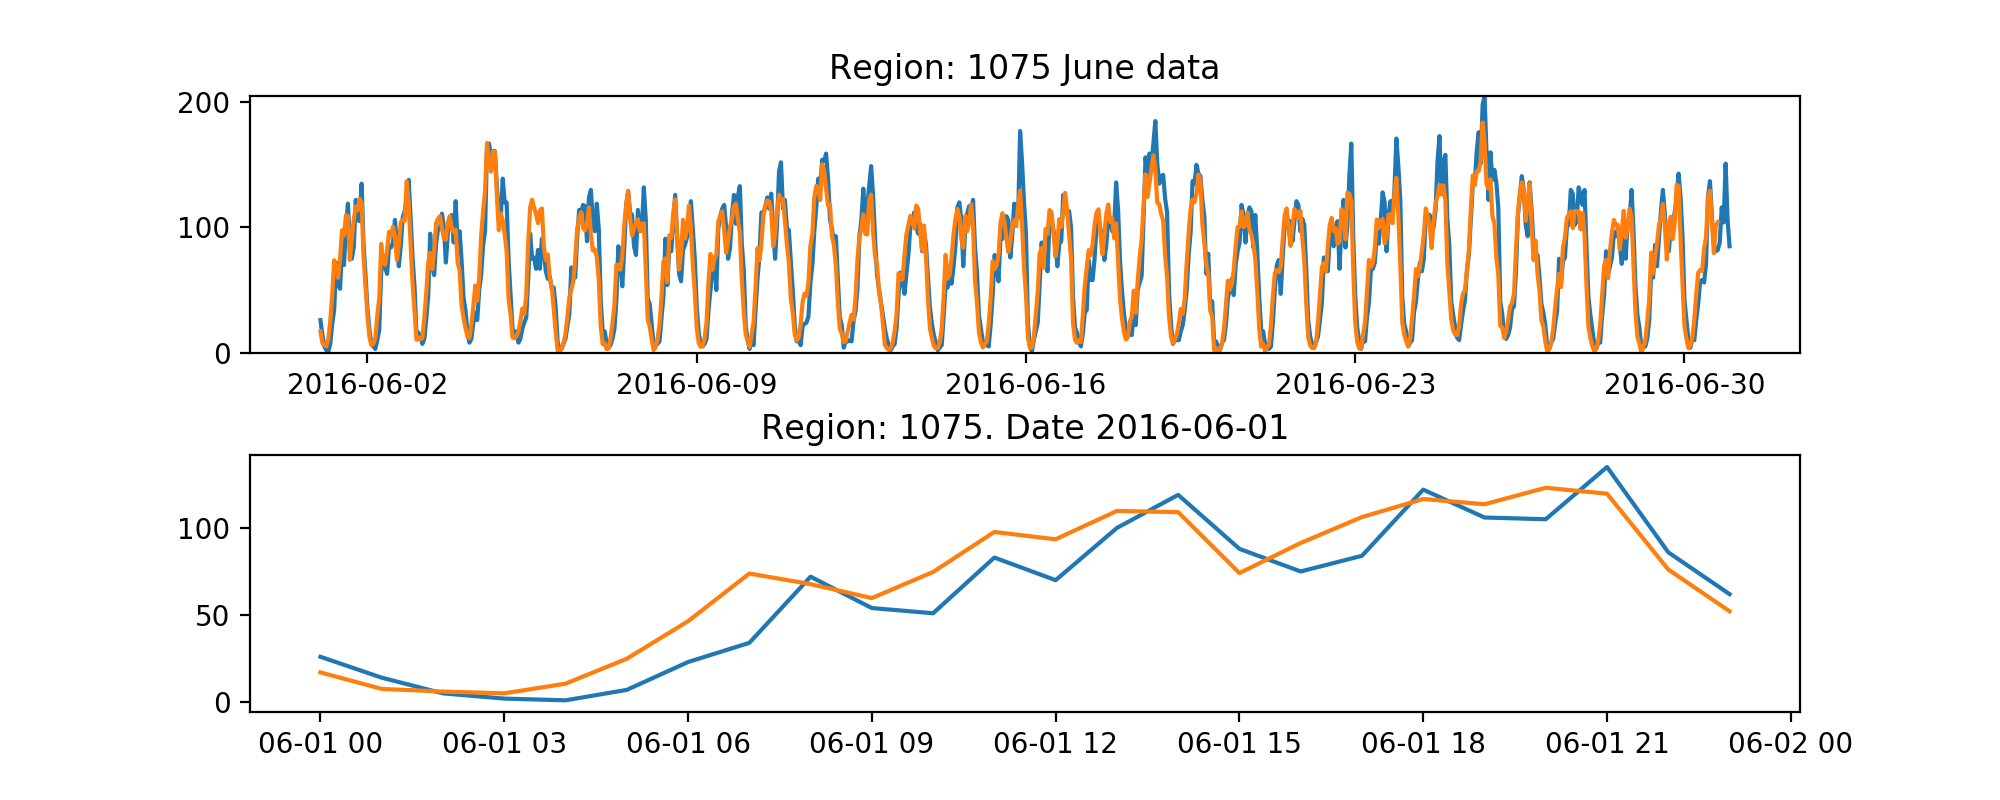

U2VsZWN0aW9uU2xpZGVyKGNvbnRpbnVvdXNfdXBkYXRlPUZhbHNlLCBkZXNjcmlwdGlvbj11J1NlbGVjdCBkYXRlJywgbGF5b3V0PUxheW91dChoZWlnaHQ9dSc4MHB4Jywgd2lkdGg9dScxMDDigKY=


TWFwKGNlbnRlcj1bNDAuNzQ4ODE3LCAtNzMuOTg1NDI4XSwgY29udHJvbHM9KFpvb21Db250cm9sKG9wdGlvbnM9W3UncG9zaXRpb24nLCB1J3pvb21faW5fdGV4dCcsIHUnem9vbV9pbl90aXTigKY=


In [4]:
empire_state_building_lon = -73.985428
empire_state_building_lat = 40.748817

selected_region_color = "red"
default_region_color = "blue"

selected_region_opacity = 0.7
default_region_opacity = 0.2

selected_date = data.datetime.min().strftime('%Y-%m-%d')
selected_region = data.region.min()

m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    
    center=(empire_state_building_lat, empire_state_building_lon),
    zoom=11
)

m.layout.width = '1000px'
m.layout.height = '450px'

rectangles = {}

for region, coords in regions.iterrows():
    rectangles[region] = Rectangle(
        bounds=((coords.north, coords.west), (coords.south, coords.east)),
        weight=2,
        color=(selected_region_color if region == selected_region else default_region_color),
        fill_color=(selected_region_color if region == selected_region else default_region_color),
        fill_opacity=(selected_region_opacity if region == selected_region else default_region_opacity),
    )
    
    
    def change_handler(region):
        def func(*args, **kwargs):
            on_region_change(region)
        return func

    rectangles[region].on_click(change_handler(region))
    m.add_layer(rectangles[region])

w = widgets.SelectionSlider(
    options=data.datetime.dt.strftime('%Y-%m-%d').unique(),
    value=selected_date,
    description='Select date',
    orientation='horizontal',
    layout=widgets.Layout(width='100%', height='80px'),
    continuous_update=False
)

def on_region_change(new_region):
    global selected_region, rectangles
    selected_region = new_region
    redraw_chart()
    
    for rect in rectangles.itervalues():
        rect.color = default_region_color
        rect.fill_color = default_region_color
        rect.fill_opacity = default_region_opacity
    
    rectangles[selected_region].color = selected_region_color
    rectangles[selected_region].fill_color = selected_region_color
    rectangles[selected_region].fill_opacity = selected_region_opacity
    


def on_date_change(val):
    global selected_date
    selected_date = val.new
    redraw_chart()

w.observe(on_date_change, names='value')

def redraw_chart():
    print "redraw"
    global fig, ax_date, ax_month, values_date, predictions_date, values_month, predictions_month, selected_region, selected_date
    selected_data_date = get_selected_data_date()
    
    values_date.set_xdata(selected_data_date.datetime.values)
    values_date.set_ydata(selected_data_date.value.values)

    predictions_date.set_xdata(selected_data_date.datetime.values)
    predictions_date.set_ydata(selected_data_date.prediction.values)
    
    ax_date.set_xlim(selected_data_date.datetime.min(),selected_data_date.datetime.max())
    ax_date.set_ylim(0, max(selected_data_date.value.max(),selected_data_date.prediction.max()))
    ax_date.set_title('Region: {}. Date {}'.format(selected_region, selected_date))
    
    selected_data_month = get_selected_data_month()
    
    values_month.set_xdata(selected_data_month.datetime.values)
    values_month.set_ydata(selected_data_month.value.values)

    predictions_month.set_xdata(selected_data_month.datetime.values)
    predictions_month.set_ydata(selected_data_month.prediction.values)
    
    ax_month.set_ylim(0, max(selected_data_month.value.max(),selected_data_month.prediction.max()))
    ax_month.set_title('Region: {} June data'.format(selected_region))

def get_selected_data_date():
    global data, selected_region, selected_date
    return data[(data.datetime.dt.strftime('%Y-%m-%d') == selected_date) & (data.region == selected_region)]

def get_selected_data_month():
    global data, selected_region
    return data[data.region == selected_region]


fig, (ax_month, ax_date) = plt.subplots(2, 1, figsize=(10,4))
plt.subplots_adjust(hspace=0.4)

selected_data_date = get_selected_data_date()
ax_date.set_title('Region: {}. Date {}'.format(selected_region, selected_date))
values_date, = ax_date.plot(selected_data_date.datetime, selected_data_date.value)
predictions_date, = ax_date.plot(selected_data_date.datetime, selected_data_date.prediction)

selected_data_month = get_selected_data_month()
ax_month.set_title('Region: {} June data'.format(selected_region))
values_month, = ax_month.plot(selected_data_month.datetime, selected_data_month.value)
predictions_month, = ax_month.plot(selected_data_month.datetime, selected_data_month.prediction)
ax_month.set_ylim(0, max(selected_data_month.value.max(),selected_data_month.prediction.max()))

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


plt.show()
display(w)
display(m)
